## Soleil DiffAbs XRD:
* [Calibration](#calibration)
* [Dark](#dark)
* [Flat](#flat)
* [Mask](#mask)
* [Integration](#integration)

TODO
- faire un mask, dark, flat correct. (voir avec SIXS).
- corriger du moniteur. (I0)

In [2]:
%pylab nbagg

import os
import functools

import h5py
import pyFAI

from collections import namedtuple
from itertools import chain
from typing import List, Optional, Tuple

from fabio.edfimage import edfimage
from h5py import File
from pyFAI.detectors import detector_factory
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

import ipywidgets as widgets


# local import
from soleil import Angle, Calibrant, CalibrationMarsTxTz, CalibrationFunctions, CalibrationMarsTxTzFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathContainsDefault, DatasetPathWithAttribute, get_dataset,\
    calibration_mars_tx_tz, integrate_mars_tx_tz, save_as_edf_mars_tx_tz

Populating the interactive namespace from numpy and matplotlib


In [3]:
ROOT = "/home/experiences/instrumentation/picca/jupyter/mars/20160800/"
PUBLISHED = os.path.join(ROOT, "published-data")

In [4]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.

json = os.path.join(PUBLISHED, "xrd", "calibration", "calibration.json")

distance = 0.258705917299
poni1_scale = 0.001
poni1_offset = 0.12
poni1x_scale = 0
poni2_scale = 0.001
poni2_offset = -0.9488181818181818
poni2z_scale = 0
rot1 = 0.0 # 0.00388272369359
rot2 = 0.0 # -0.00942588451226
rot3 = 0.0 # 7.19961198098e-07


functions = (
    CalibrationFunctions("dist",
                         "tz * poni1_scale + poni1_offset + tx * poni1x_scale",
                         "tx * poni2_scale + poni2_offset + tz * poni2z_scale",
                         "rot1",
                         "rot2",
                         "rot3"),    
    [Parameter[Length]("dist", distance, (distance-0.05, distance+0.05)),
     Parameter[float]("poni1_scale", poni1_scale, (poni1_scale, poni1_scale)),
     Parameter[Length]("poni1_offset", poni1_offset, (poni1_offset-1, poni1_offset+1)),
     Parameter[float]("poni1x_scale", poni1x_scale, (poni1x_scale-0.01, poni1x_scale+0.01)),
     Parameter[float]("poni2_scale", poni2_scale, (poni2_scale, poni2_scale)),
     Parameter[Length]("poni2_offset", poni2_offset, (poni2_offset-1, poni2_offset+1)),
     Parameter[float]("poni2z_scale", poni2z_scale, (poni2z_scale-0.01, poni2z_scale+0.01)),
     Parameter[Angle]("rot1", rot1, (rot1-0.1, rot1+0.1)),
     Parameter[float]("rot2", rot2, (rot2-0.1, rot2+0.1)),
     Parameter[Angle]("rot3", rot3, (rot3, rot3))]
)

# conserve the image available for calibration, remove others
def to_use(frame: CalibrationMarsTxTzFrame) -> bool:
   
    return True if frame.idx in range(0,30) else False

def mkCalibrationMarsTxTz(filename: str, tz: float, idxs: List[int]):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd", "calibration"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("scan_data/actuator_1_1"),  # tx
                               #tz, # tz
                               DatasetPathContainsDefault("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value", tz),  # tz
                               idxs,
                               to_use,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions,
                               18 ## max_rings
                              ) 
    
params = [mkCalibrationMarsTxTz(os.path.join(ROOT, "scan_3_01.nxs"), 0.0, [2, 5, 8]),
          mkCalibrationMarsTxTz(os.path.join(ROOT, "scan_4_01.nxs"), -1.0, [2, 5])]

In [5]:
from functools import partial

def on_click_button(cmd, b):
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [6]:
emacs = my_cmd_button("emacs soleil.py", "Edit the soleil.py file")

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [7]:
for param in params:
    my_cmd_button("silx view --use-opengl-plot " + param.filename,
                  'Silx View ' + os.path.basename(param.filename))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


In [8]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

for param in params:
    cmds = save_as_edf_mars_tx_tz(param)
    for cmd, idx in zip(cmds, param.idxs):
        my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(param.filename) + " " + str(idx))

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"
Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.568192e-01m	PONI= 1.379994e-01, -3.197165e-02m	rot1=0.008095  rot2= -0.028732  rot3= -0.000000 rad
DirectBeamDist= 256.934mm	Center: x=-261.928, y=1004.756 pix	Tilt=1.710 deg  tiltPlanRotation= -105.730 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.591094e-01m	PONI= 1.322339e-01, 3.374004e-02m	rot1=0.008648  rot2= -0.007054  rot3= -0.000000 rad
DirectBeamDist= 259.126mm	Center: x=242.302, y=1003.123 pix	Tilt=0.639 deg  tiltPlanRotation= -140.794 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.593292e-01m	PONI= 1.310089e-01, 1.001319e-01m	rot1=0.010198  rot2= -0.002498  rot3= 0.000000 rad
DirectBeamDist= 259.343mm	Center: x=749.900, y=1002.778 pix	Tilt=0.602 deg  tiltPlanRotation= -166.238 deg
Fil

<IPython.core.display.Javascript object>


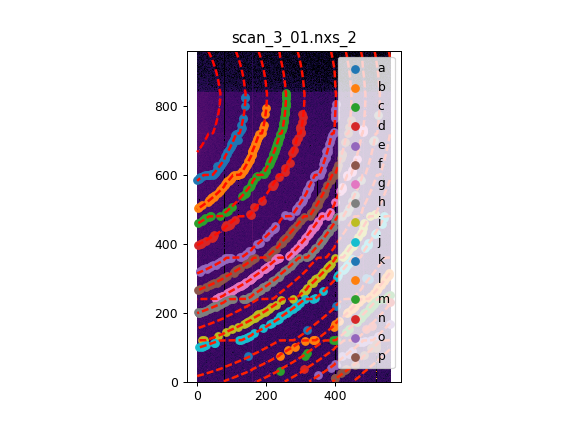

<IPython.core.display.Javascript object>


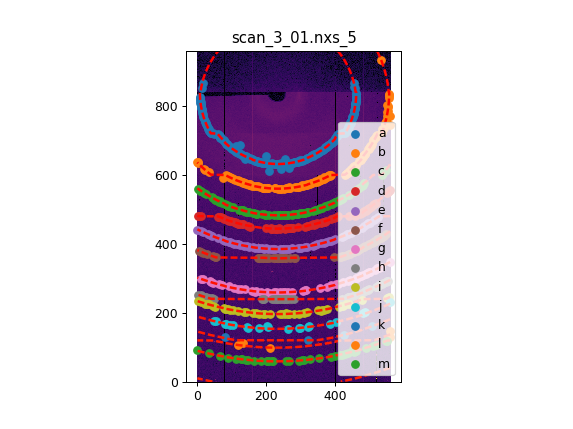

<IPython.core.display.Javascript object>


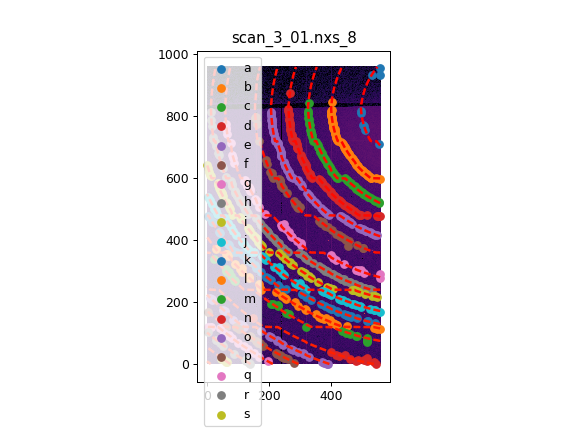

Cost function before refinement: 0.135554073845
[ 0.25870592  0.001       0.12        0.          0.001      -0.94881818
  0.          0.          0.          0.        ]
     fun: 1.7675573171862565e-06
     jac: array([  4.91290988e-05,   0.00000000e+00,  -4.02004471e-05,
        -2.26203431e-02,   4.08878439e-02,   7.56645381e-05,
         0.00000000e+00,  -4.88869505e-05,   2.37804405e-05,
        -1.42108547e-14,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 251
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([  2.60157838e-01,   1.00000000e-03,   1.36461690e-01,
        -9.42012306e-06,   1.00000000e-03,  -7.71409002e-01,
         0.00000000e+00,  -1.05838538e-02,   6.00798101e-03,
         0.00000000e+00])
Cost function after refinement: 1.76755731719e-06
GonioParam(dist=0.2601578381810542, poni1_scale=0.001, poni1_offset=0.13646169003681552, poni1x_scale=-9.4201230567560366e-06, poni2_scale=0.001, poni2_offset=-0.77140900223

scan_3_01.nxs_0
ControlPoints instance containing 17 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 17 groups of points:
# t ring 6: 34 points
# u ring 7: 43 points
# v ring 8: 45 points
# w ring 9: 50 points
# x ring 10: 54 points
# y ring 11: 3 points
# z ring 12: 57 points
#aa ring 13: 61 points
#ab ring 14: 63 points
#ac ring 15: 62 points
#ad ring 16: 64 points
#ae ring 17: 66 points
#af ring 18: 44 points
#ag ring 19: 36 points
#ah ring 20: 24 points
#ai ring 21: 20 points
#aj ring 22: 16 points



scan_3_01.nxs_1
ControlPoints instance containing 18 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 18 groups of points:
#ak ring 3: 36 points
#al ring 4: 46 points
#am ring 5: 53 points
#an ring 6: 58 points
#ao ring 7: 18 points
#ap ring 8: 62 points
#aq ring 9: 64 points
#ar ring 10: 66 points
#as ring 11: 69 points
#at ring 12: 70 points
#au ring 13: 55 points
#av ring 14: 48 points
#aw ring 15: 44 points
#ax ring 16: 37 points
#ay ring 17: 31 points
#az ring 18: 25 points
#ba ring 19: 20 points
#bb ring 20: 11 points


scan_3_01.nxs_3
ControlPoints instance containing 18 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 18 groups of points:
#bc ring 0: 93 points
#bd ring 1: 93 points
#be ring 2: 90 points
#bf ring 3: 91 points
#bg ring 4: 89 points
#bh ring 5: 90 points
#bi ring 6: 67 points
#bj ring 7: 58 points
#bk ring 8: 54 points
#bl ring 9: 49 points
#bm ring 10: 44 points
#bn ring 



scan_3_01.nxs_9
ControlPoints instance containing 17 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 17 groups of points:
#dq ring 2: 52 points
#dr ring 3: 60 points
#ds ring 4: 63 points
#dt ring 5: 66 points
#du ring 6: 69 points
#dv ring 7: 26 points
#dw ring 8: 72 points
#dx ring 9: 74 points
#dy ring 10: 76 points
#dz ring 11: 75 points
#ea ring 12: 57 points
#eb ring 13: 45 points
#ec ring 14: 43 points
#ed ring 15: 34 points
#ee ring 16: 28 points
#ef ring 17: 22 points
#eg ring 18: 17 points



scan_3_01.nxs_10
ControlPoints instance containing 18 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 18 groups of points:
#eh ring 4: 33 points
#ei ring 5: 41 points
#ej ring 6: 52 points
#ek ring 7: 56 points
#el ring 8: 58 points
#em ring 9: 60 points
#en ring 10: 2 points
#eo ring 11: 4 points
#ep ring 12: 67 points
#eq ring 13: 68 points
#er ring 14: 69 points
#es ring 15: 62 points
#et ring 16: 17 points
#eu ring 17: 39 points
#ev ring 18: 32 points
#ew ring 19: 27 points
#ex ring 20: 17 points
#ey ring 21: 13 points
**************************************************
Cost function before refinement: 1.28662826439e-06
[  2.60157838e-01   1.00000000e-03   1.36461690e-01  -9.42012306e-06
   1.00000000e-03  -7.71409002e-01   0.00000000e+00  -1.05838538e-02
   6.00798101e-03   0.00000000e+00]
     fun: 1.1177252346219403e-06
     jac: array([ -3.74533441e-05,   0.00000000e+00,   1.90719331e-05,
         1.83337596e-02,   3.71320735e-02, 

<IPython.core.display.Javascript object>


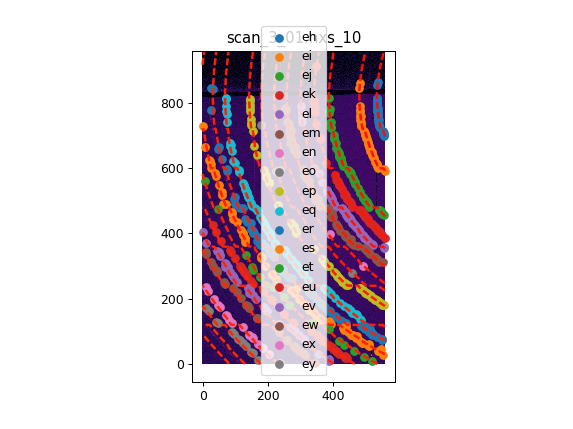

<IPython.core.display.Javascript object>


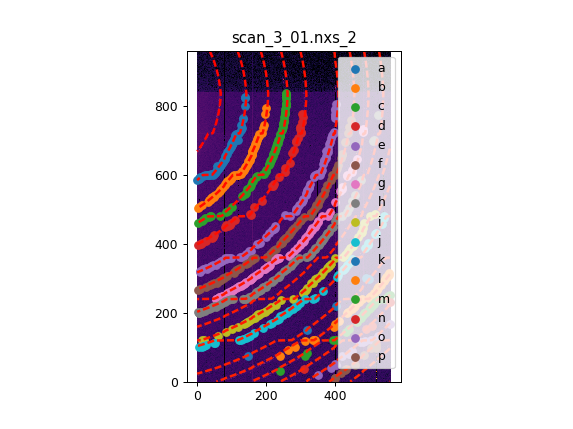

<IPython.core.display.Javascript object>


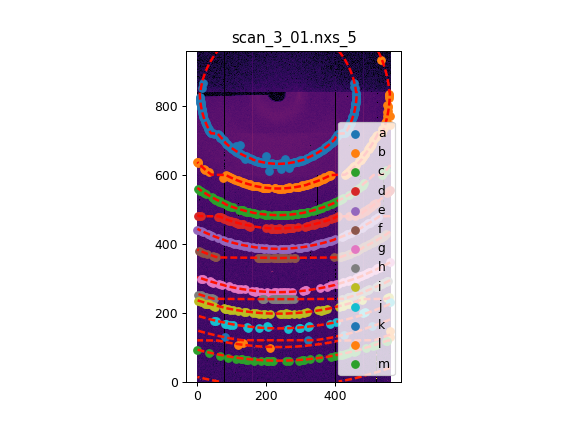

<IPython.core.display.Javascript object>


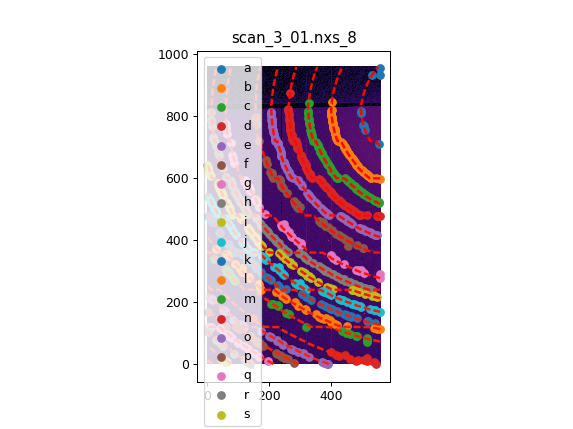

<IPython.core.display.Javascript object>


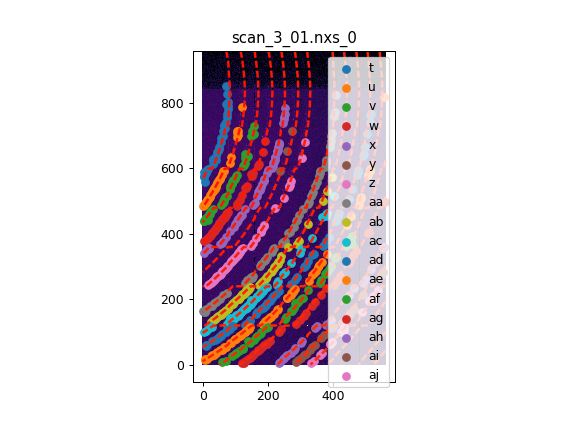

<IPython.core.display.Javascript object>


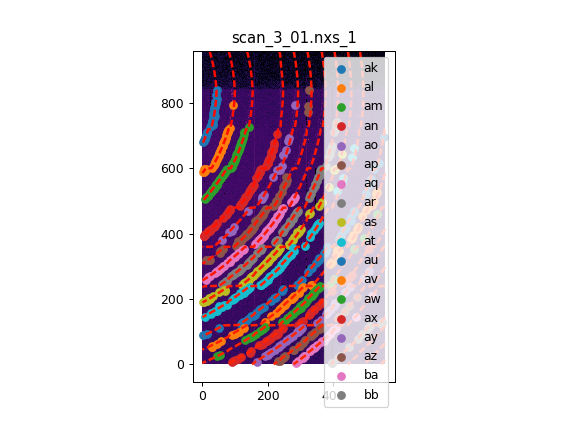

<IPython.core.display.Javascript object>


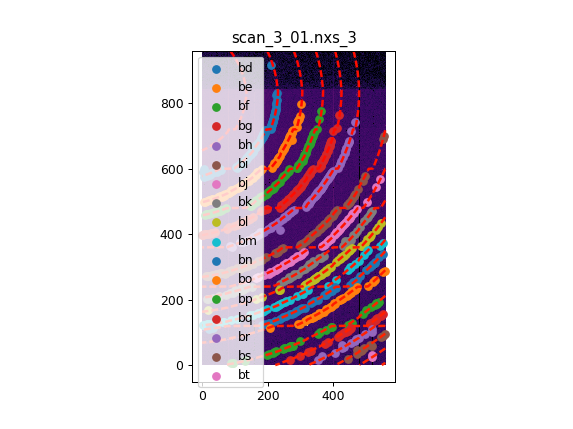

<IPython.core.display.Javascript object>


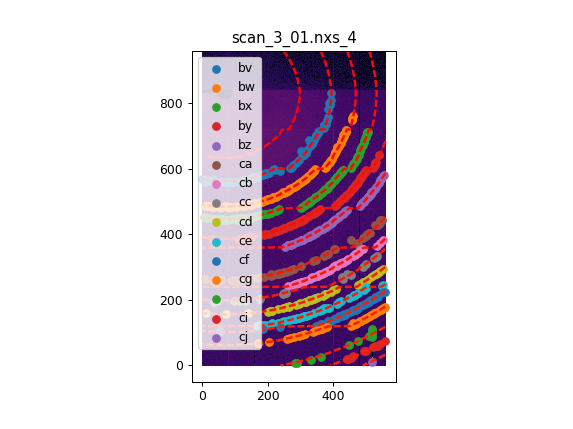

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


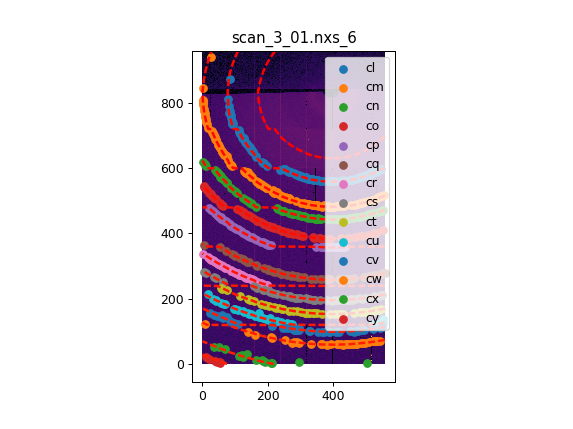

<IPython.core.display.Javascript object>


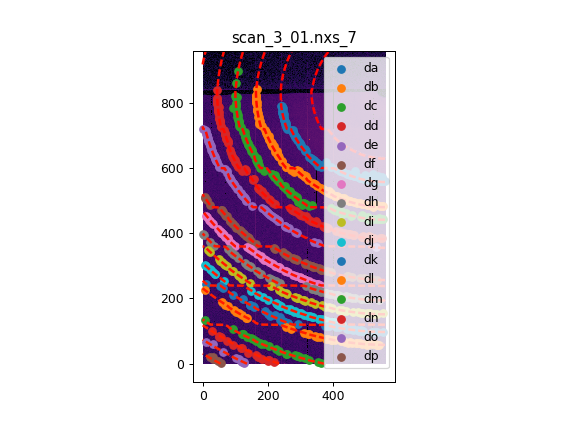

<IPython.core.display.Javascript object>


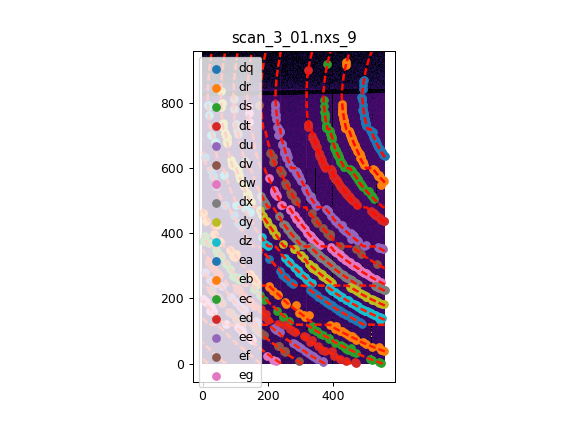

<IPython.core.display.Javascript object>


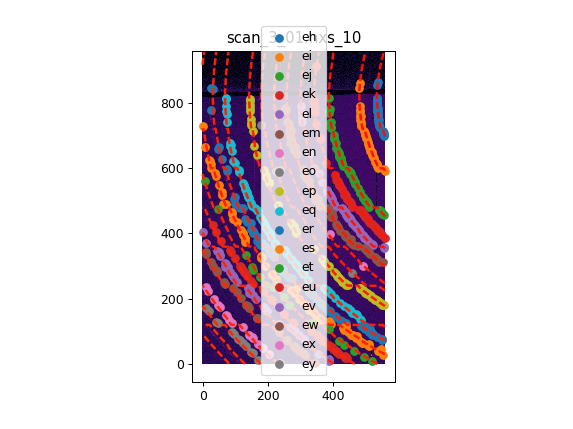

GoniometerRefinement with 11 geometries labeled: scan_3_01.nxs_2, scan_3_01.nxs_5, scan_3_01.nxs_8, scan_3_01.nxs_0, scan_3_01.nxs_1, scan_3_01.nxs_3, scan_3_01.nxs_4, scan_3_01.nxs_6, scan_3_01.nxs_7, scan_3_01.nxs_9, scan_3_01.nxs_10.
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.580861e-01m	PONI= 1.309598e-01, -3.359912e-02m	rot1=0.003605  rot2= -0.007531  rot3= 0.000000 rad
DirectBeamDist= 258.095mm	Center: x=-265.611, y=992.430 pix	Tilt=0.478 deg  tiltPlanRotation= -115.577 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.580452e-01m	PONI= 1.327273e-01, 3.184944e-02m	rot1=0.001541  rot2= -0.013459  rot3= 0.000000 rad
DirectBeamDist= 258.069mm	Center: x=241.937, y=994.263 pix	Tilt=0.776 deg  tiltPlanRotation= -96.531 deg
Filled refinement object:
GoniometerRefinement with 13 geometries labeled: scan_3_01.nxs_2, scan_3_01.nxs_5, scan_3_01.nxs_8, scan_3_01.nxs_0, scan_3_01

<IPython.core.display.Javascript object>


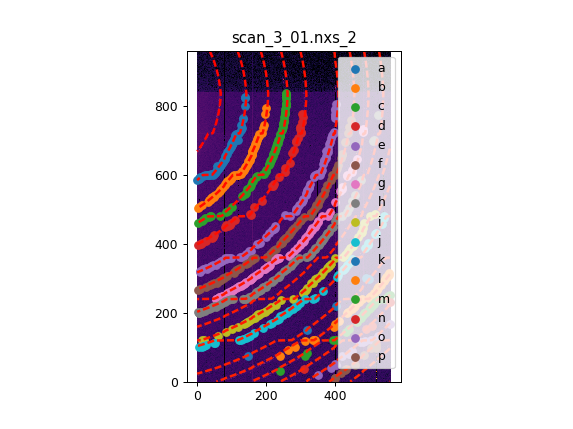

<IPython.core.display.Javascript object>


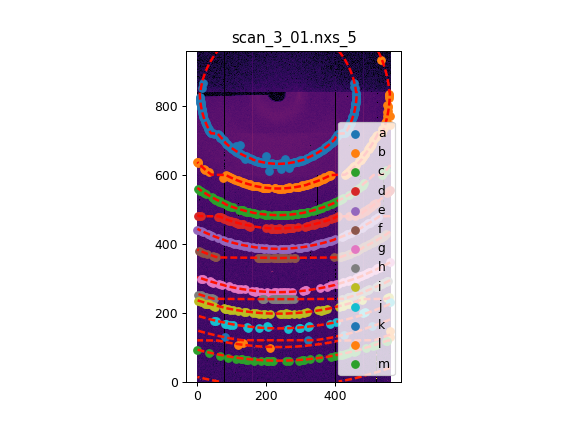

<IPython.core.display.Javascript object>


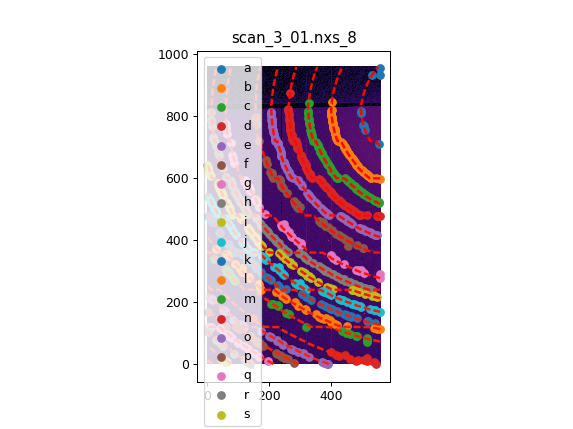

<IPython.core.display.Javascript object>


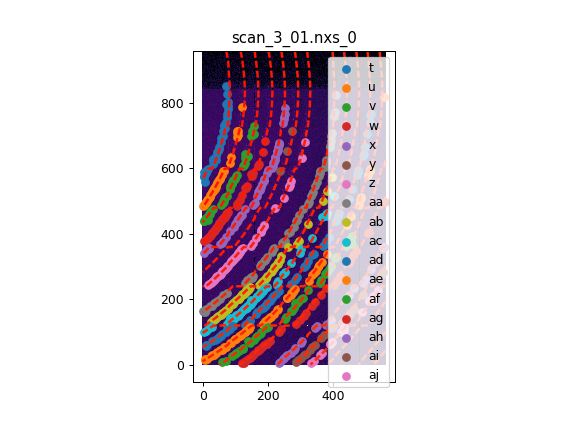

<IPython.core.display.Javascript object>


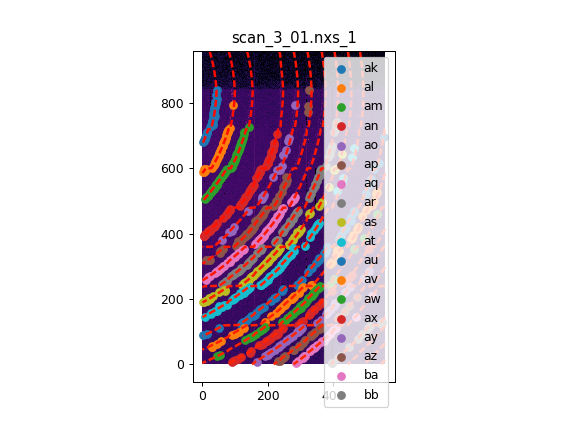

<IPython.core.display.Javascript object>


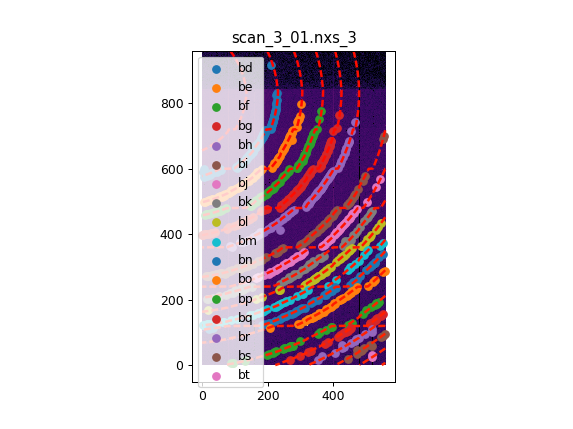

<IPython.core.display.Javascript object>


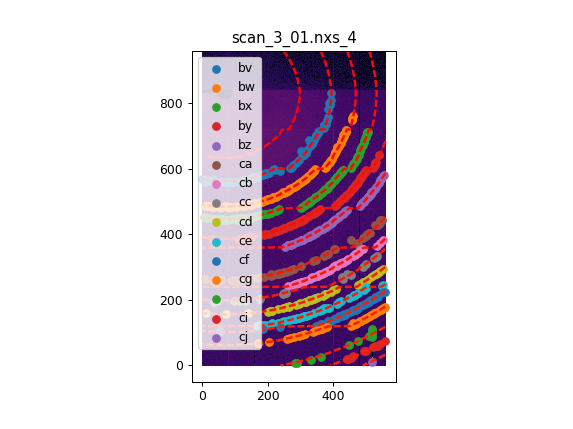

<IPython.core.display.Javascript object>


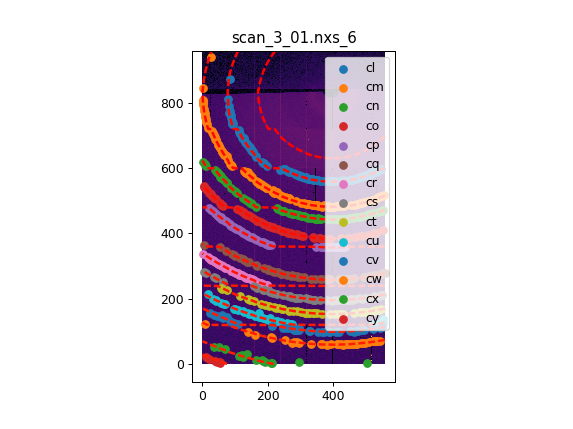

<IPython.core.display.Javascript object>


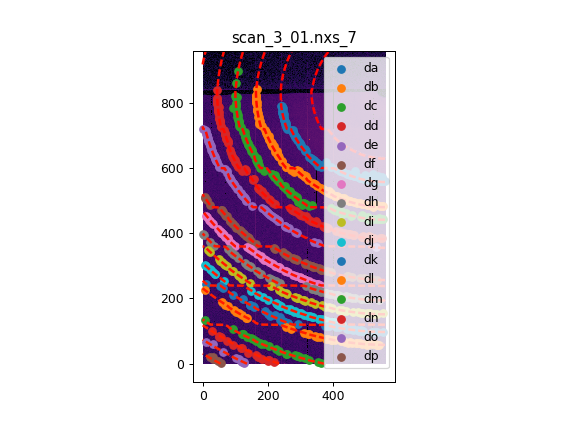

<IPython.core.display.Javascript object>


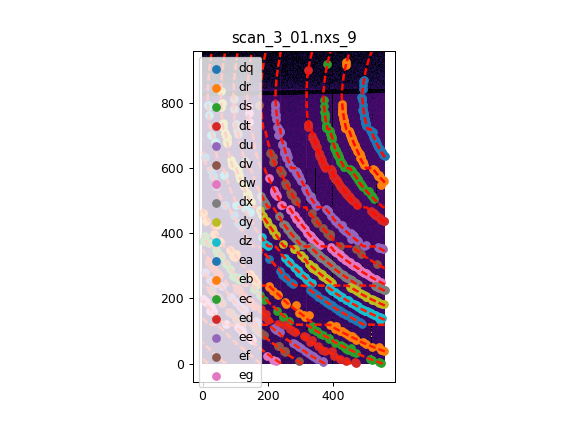

<IPython.core.display.Javascript object>


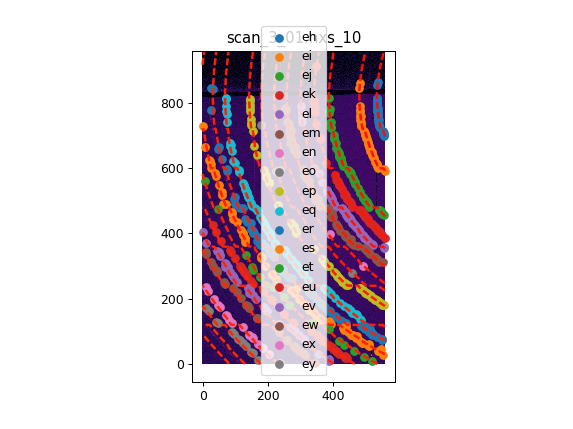

<IPython.core.display.Javascript object>


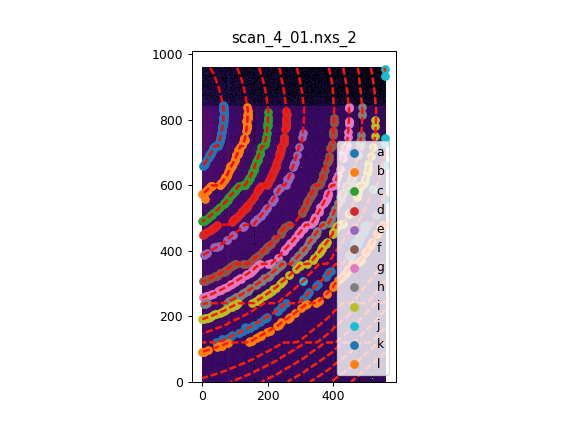

<IPython.core.display.Javascript object>


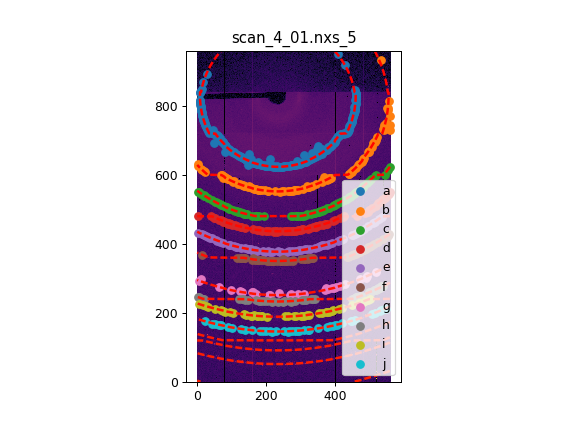

Cost function before refinement: 1.23573967538e-06
[  2.59995790e-01   1.00000000e-03   1.36959656e-01  -8.63805995e-06
   1.00000000e-03  -7.69355732e-01   0.00000000e+00  -3.35111305e-03
   1.92657801e-03   0.00000000e+00]
     fun: 1.155195796318082e-06
     jac: array([ -1.64304865e-06,  -1.90600031e-04,  -2.18757458e-05,
        -3.93394347e-03,   1.85363735e-02,  -3.53003602e-05,
         4.15135078e-06,   9.83797227e-06,   4.95417524e-07,
        -3.12638804e-13,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 171
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([  2.59735306e-01,   1.00000000e-03,   1.36816748e-01,
        -7.85224085e-06,   1.00000000e-03,  -7.69656604e-01,
         7.67471926e-05,  -4.23118829e-03,  -1.88233039e-04,
         0.00000000e+00])
Cost function after refinement: 1.15519579632e-06
GonioParam(dist=0.25973530562152375, poni1_scale=0.001, poni1_offset=0.13681674772724781, poni1x_scale=-7.85224085113184

scan_4_01.nxs_0
ControlPoints instance containing 17 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 17 groups of points:
# k ring 6: 34 points
# l ring 7: 44 points
# m ring 8: 47 points
# n ring 9: 50 points
# o ring 10: 54 points
# p ring 11: 5 points
# q ring 12: 57 points
# r ring 13: 60 points
# s ring 14: 62 points
# t ring 15: 62 points
# u ring 16: 65 points
# v ring 17: 67 points
# w ring 18: 45 points
# x ring 19: 36 points
# y ring 20: 25 points
# z ring 21: 20 points
#aa ring 22: 15 points



scan_4_01.nxs_1
ControlPoints instance containing 18 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 18 groups of points:
#ab ring 3: 37 points
#ac ring 4: 47 points
#ad ring 5: 53 points
#ae ring 6: 60 points
#af ring 7: 14 points
#ag ring 8: 63 points
#ah ring 9: 65 points
#ai ring 10: 68 points
#aj ring 11: 68 points
#ak ring 12: 68 points
#al ring 13: 57 points
#am ring 14: 50 points
#an ring 15: 44 points
#ao ring 16: 36 points
#ap ring 17: 29 points
#aq ring 18: 24 points
#ar ring 19: 20 points
#as ring 20: 11 points


scan_4_01.nxs_3
ControlPoints instance containing 18 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 18 groups of points:
#at ring 0: 96 points
#au ring 1: 91 points
#av ring 2: 90 points
#aw ring 3: 92 points
#ax ring 4: 91 points
#ay ring 5: 91 points
#az ring 6: 70 points
#ba ring 7: 57 points
#bb ring 8: 52 points
#bc ring 9: 48 points
#bd ring 10: 45 points
#be ring 


scan_4_01.nxs_9
ControlPoints instance containing 17 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 17 groups of points:
#dz ring 2: 53 points
#ea ring 3: 60 points
#eb ring 4: 64 points
#ec ring 5: 67 points
#ed ring 6: 72 points
#ee ring 7: 36 points
#ef ring 8: 73 points
#eg ring 9: 73 points
#eh ring 10: 76 points
#ei ring 11: 77 points
#ej ring 12: 56 points
#ek ring 13: 45 points
#el ring 14: 41 points
#em ring 15: 33 points
#en ring 16: 25 points
#eo ring 17: 21 points
#ep ring 18: 16 points



scan_4_01.nxs_10
ControlPoints instance containing 18 group of point:
LaB6 Calibrant with 245 reflections at wavelength 4.85945727522e-11
Containing 18 groups of points:
#eq ring 4: 34 points
#er ring 5: 43 points
#es ring 6: 53 points
#et ring 7: 57 points
#eu ring 8: 58 points
#ev ring 9: 60 points
#ew ring 10: 3 points
#ex ring 11: 65 points
#ey ring 12: 66 points
#ez ring 13: 68 points
#fa ring 14: 70 points
#fb ring 15: 59 points
#fc ring 16: 13 points
#fd ring 17: 38 points
#fe ring 18: 31 points
#ff ring 19: 25 points
#fg ring 20: 16 points
#fh ring 21: 12 points
**************************************************
Cost function before refinement: 1.07371466248e-06
[  2.59735306e-01   1.00000000e-03   1.36816748e-01  -7.85224085e-06
   1.00000000e-03  -7.69656604e-01   7.67471926e-05  -4.23118829e-03
  -1.88233039e-04   0.00000000e+00]
     fun: 1.071503259160253e-06
     jac: array([  6.04347903e-07,  -5.01321045e-05,  -2.88708154e-05,
        -8.54458297e-04,   1.20560761e-02, 

<IPython.core.display.Javascript object>


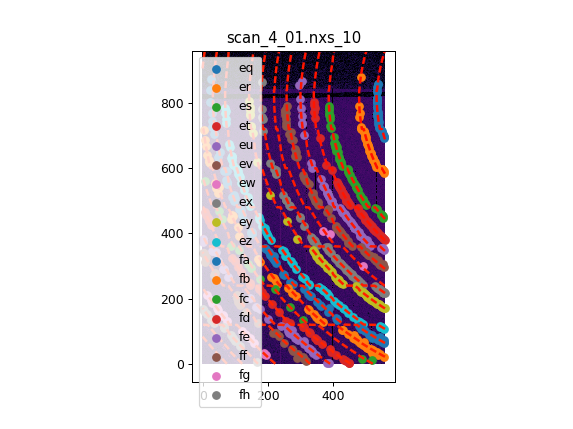

<IPython.core.display.Javascript object>


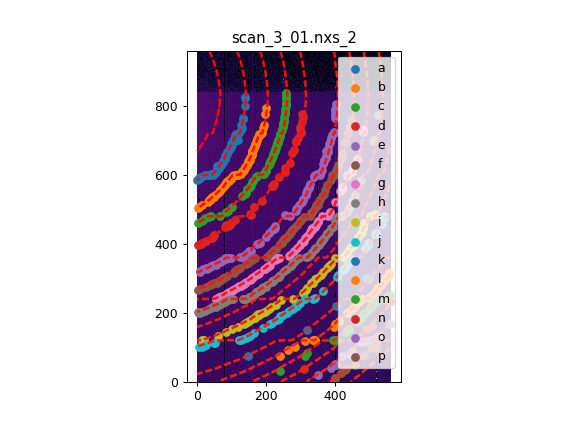

<IPython.core.display.Javascript object>


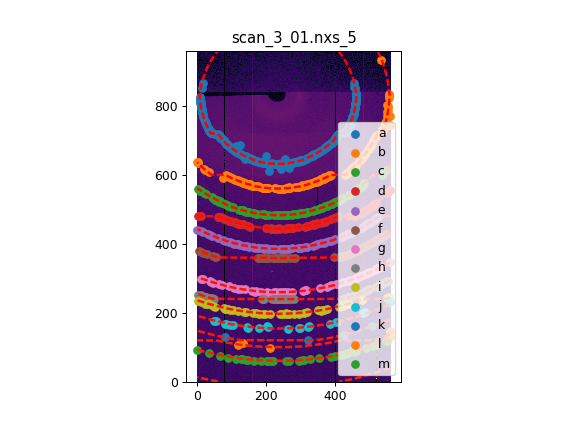

<IPython.core.display.Javascript object>


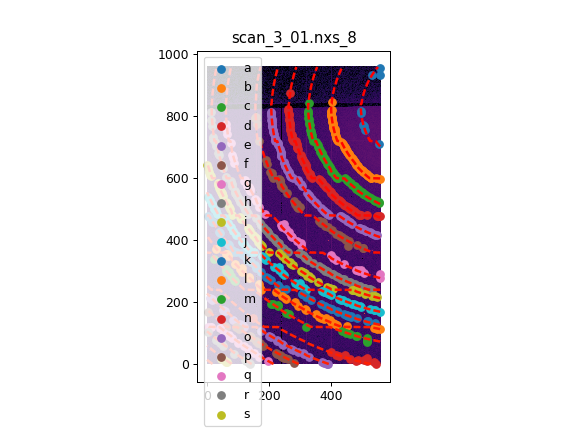

<IPython.core.display.Javascript object>


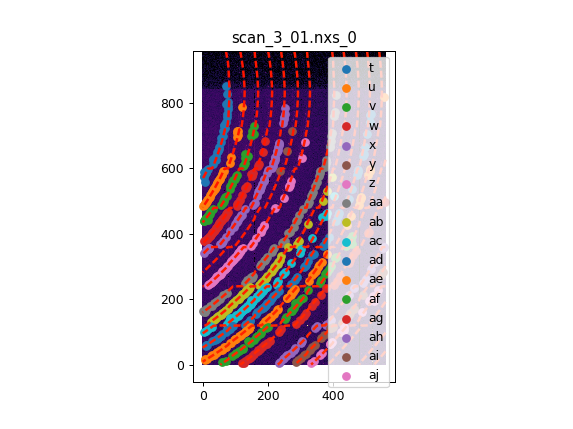

<IPython.core.display.Javascript object>


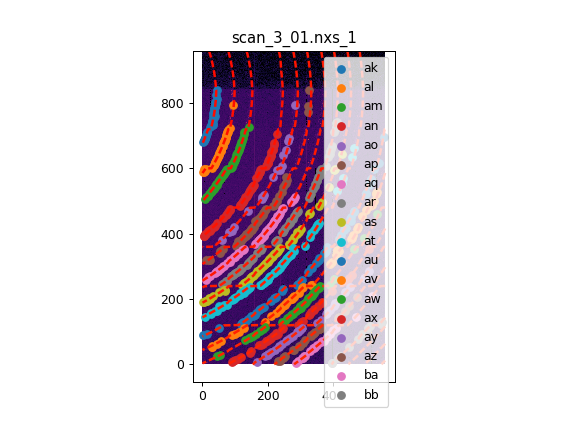

<IPython.core.display.Javascript object>


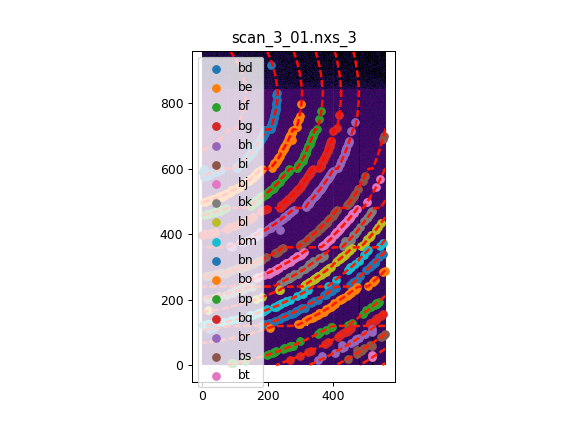

<IPython.core.display.Javascript object>


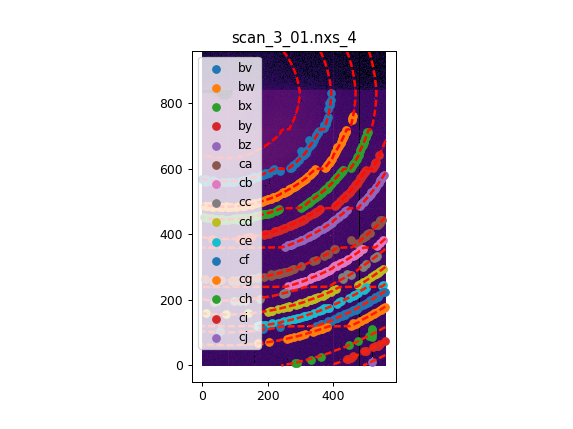

<IPython.core.display.Javascript object>


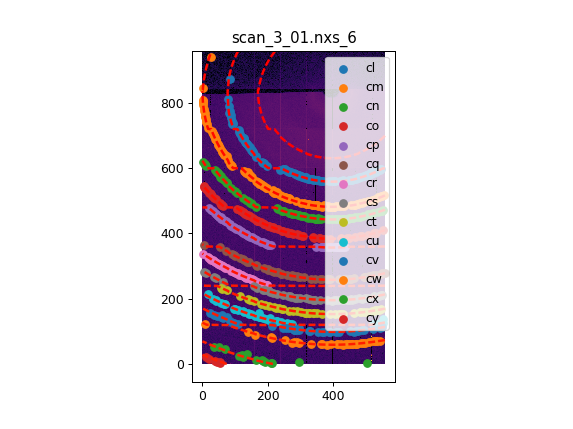

<IPython.core.display.Javascript object>


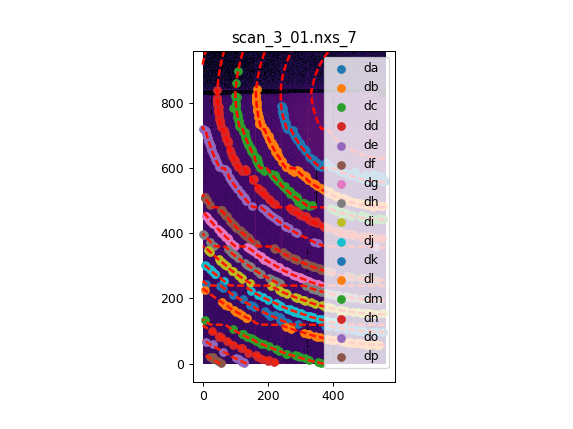

<IPython.core.display.Javascript object>


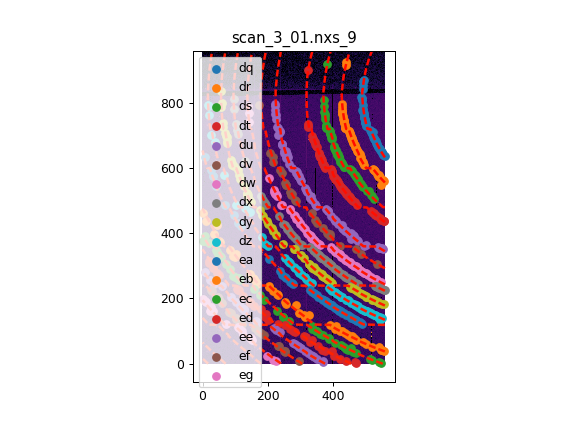

<IPython.core.display.Javascript object>


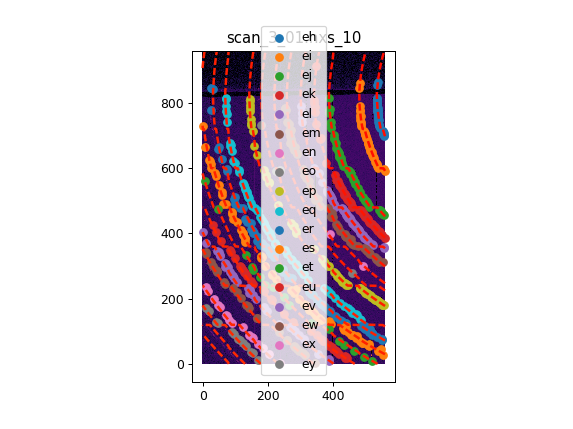

<IPython.core.display.Javascript object>


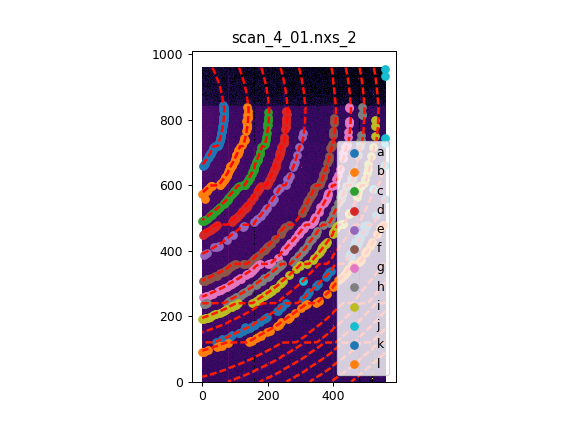

<IPython.core.display.Javascript object>


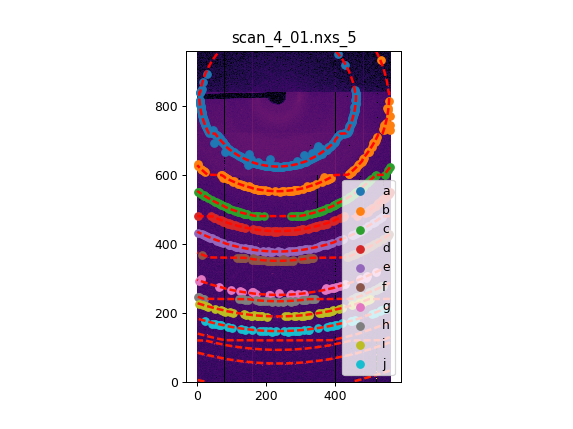

<IPython.core.display.Javascript object>


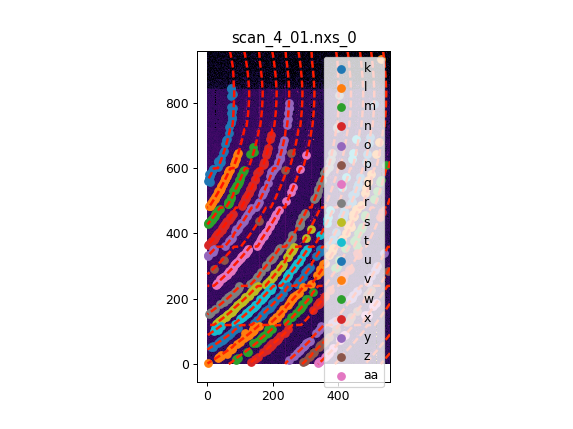

<IPython.core.display.Javascript object>


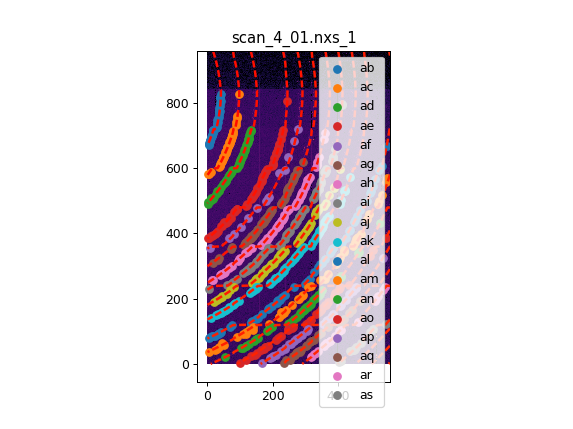

<IPython.core.display.Javascript object>


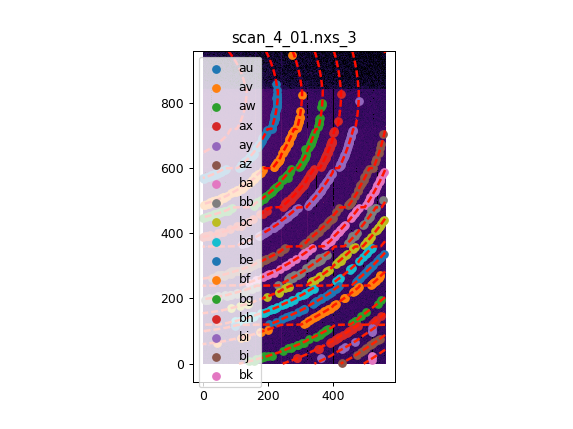

<IPython.core.display.Javascript object>


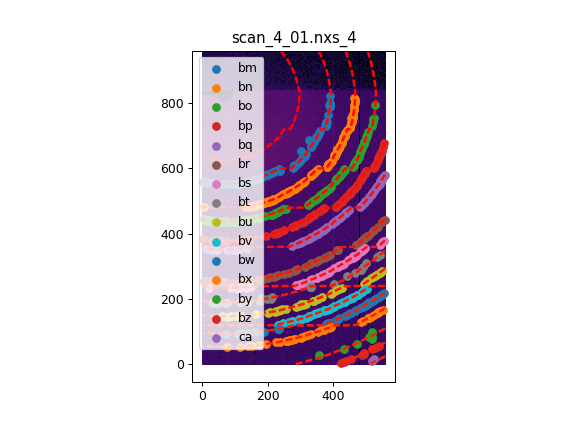

<IPython.core.display.Javascript object>


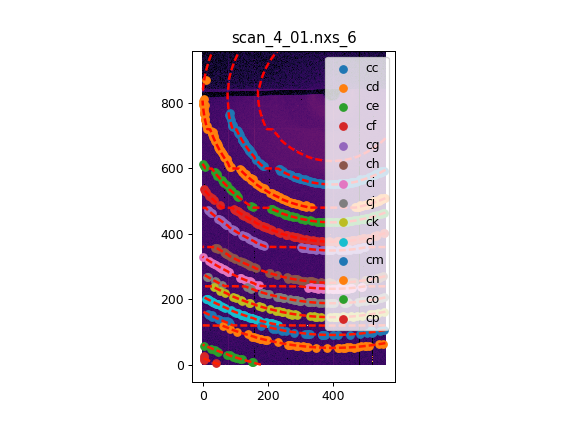

<IPython.core.display.Javascript object>


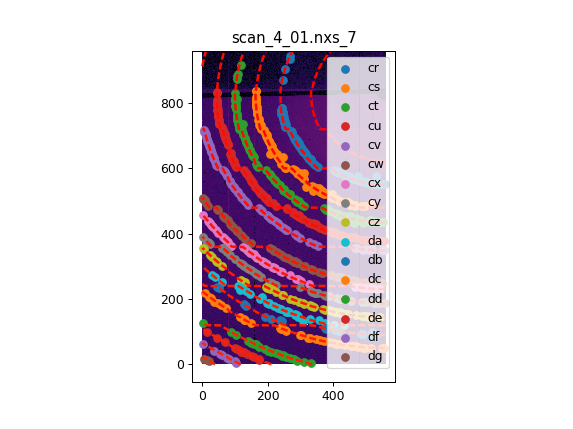

<IPython.core.display.Javascript object>


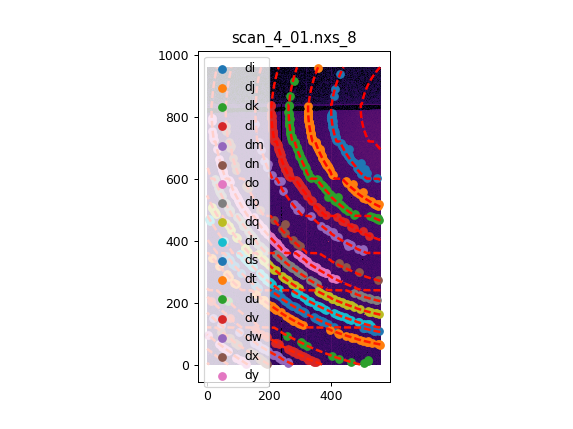

<IPython.core.display.Javascript object>


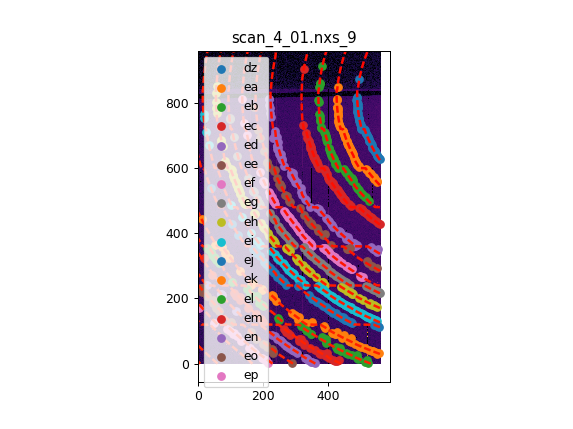

<IPython.core.display.Javascript object>


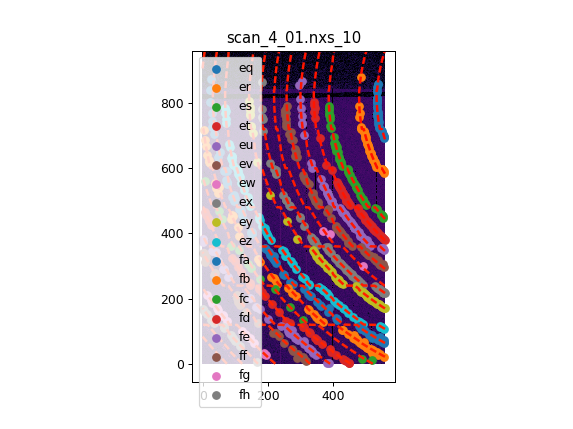

GoniometerRefinement with 22 geometries labeled: scan_3_01.nxs_2, scan_3_01.nxs_5, scan_3_01.nxs_8, scan_3_01.nxs_0, scan_3_01.nxs_1, scan_3_01.nxs_3, scan_3_01.nxs_4, scan_3_01.nxs_6, scan_3_01.nxs_7, scan_3_01.nxs_9, scan_3_01.nxs_10, scan_4_01.nxs_2, scan_4_01.nxs_5, scan_4_01.nxs_0, scan_4_01.nxs_1, scan_4_01.nxs_3, scan_4_01.nxs_4, scan_4_01.nxs_6, scan_4_01.nxs_7, scan_4_01.nxs_8, scan_4_01.nxs_9, scan_4_01.nxs_10.

In [25]:
# execute the calibration

calibration_mars_tx_tz(params, json)

area_pixel=2.8040269320227864 area_sum=3.872373118552466, Error= -0.38100425296521295


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


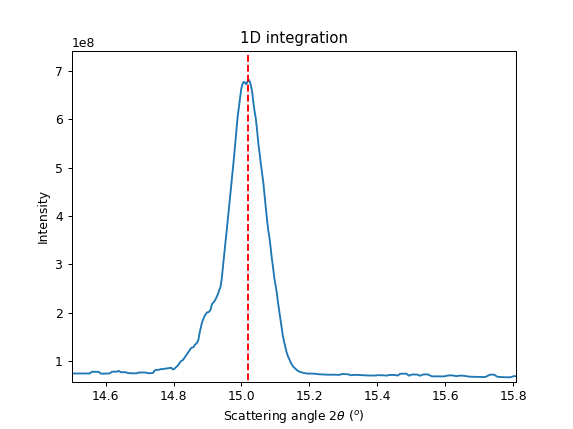

(array([  1.80000021e-03,   5.40000021e-03,   9.00000021e-03, ...,
          1.79991000e+02,   1.79994600e+02,   1.79998200e+02]),
 array([       0.        ,  5403927.26027618,  5349190.27035902, ...,
               0.        ,        0.        ,        0.        ]))

In [26]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate_mars_tx_tz(json, params, f, plot_calibrant=True, n=50000)

## Mask  <a name="mask"></a>

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


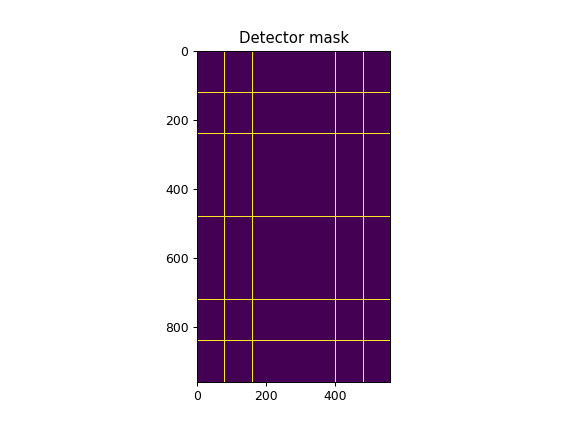

<IPython.core.display.Javascript object>


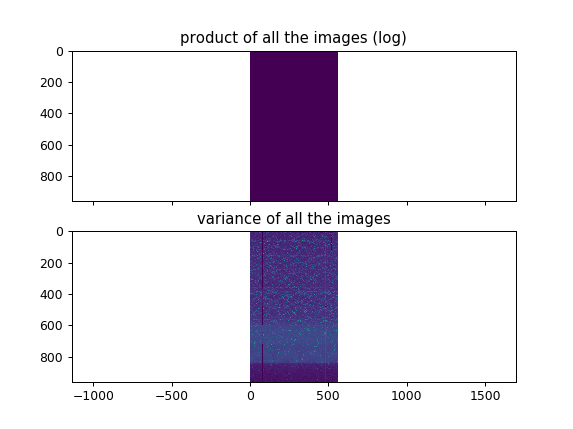

<IPython.core.display.Javascript object>


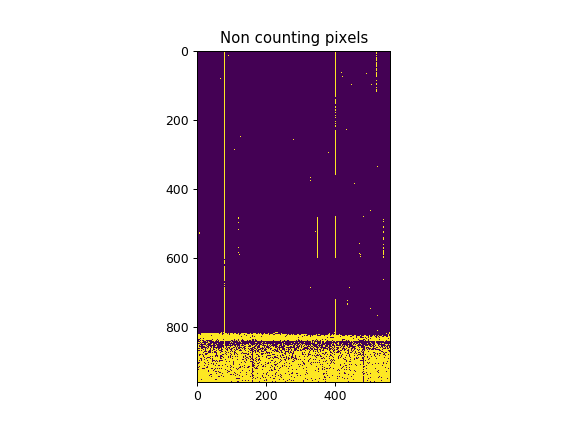

<IPython.core.display.Javascript object>


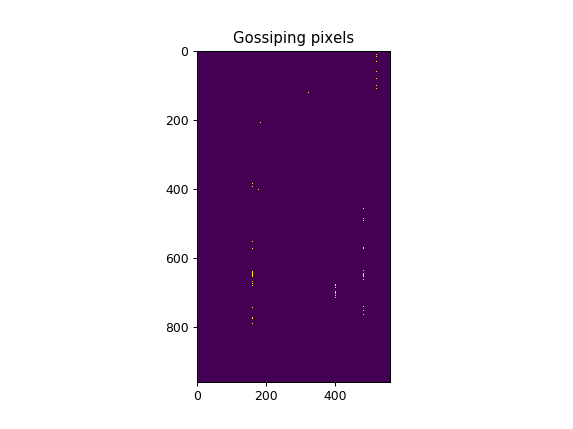

<IPython.core.display.Javascript object>


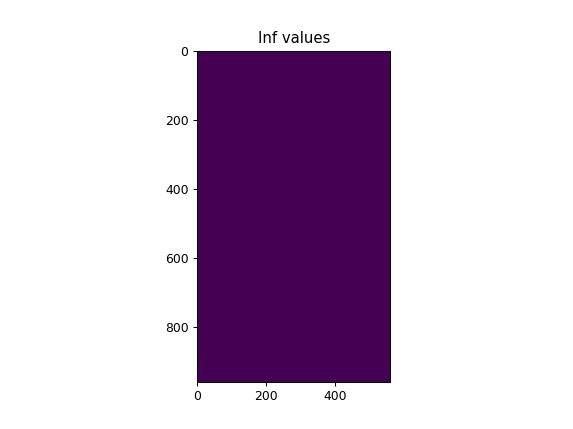

<IPython.core.display.Javascript object>


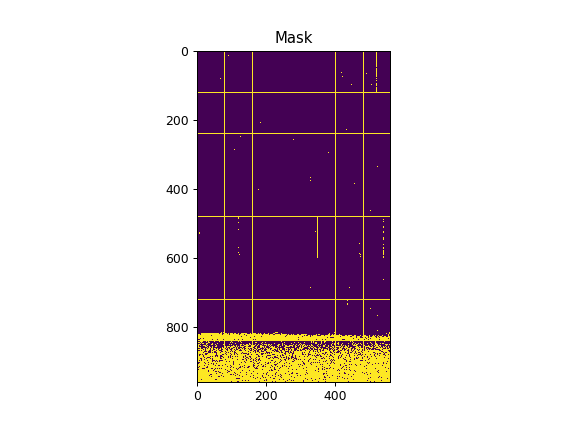

In [27]:
# create a bunch of function used to generate the mask

def mask_from_detector(detector: str) -> numpy.ndarray:
        det = detector_factory(detector)
        mask = det.calc_mask() ## int8
        
        # on a repere des discidents
        #mask[:, 527:529] = 1
        #mask[1, 413] = 1
        #mask[3, 530] = 1
        #mask[186, 333] = 1
        #mask[233, 281] = 1
        
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask)
        ax.set_title("Detector mask")

        return mask
    
def mask_from_data(params: CalibrationMarsTxTz) -> numpy.ndarray:
    prod_threshold = 1
    always_threshold = 660
    prod_gossiping = 1e20
    
    with File(params.filename, mode='r') as h5file:
        images = get_dataset(h5file, params.images_path)[:].astype('double')
        
        # product and variance of all the images
        prod = images.prod(axis=0)
        var = images.var(axis=0)
        fig, ax = pylab.subplots(2, 1, sharex=True, sharey=True)
        ax0 = ax[0]
        ax0.set_title('product of all the images (log)')
        #ax0.imshow(numpy.log(prod+1.0))
        ax0.imshow(prod)
        ax1 = ax[1]
        ax1.set_title('variance of all the images')
        ax1.imshow(numpy.log(var+1.0))

        # remove the non counting pixels
        mask_non_counting = numpy.where(prod < prod_threshold, 1, 0).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_non_counting)
        ax.set_title("Non counting pixels")
        
        # remove the gossiping pixels
        mask_gossiping = numpy.where(prod > prod_gossiping, 1, 0).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_gossiping)
        ax.set_title("Gossiping pixels")
        
        # remove the inf values
        mask_inf = numpy.isinf(prod).astype('int8')
        fig, ax = pylab.subplots(1, 1)
        ax.imshow(mask_inf)
        ax.set_title("Inf values")

        mask = mask_non_counting.copy()
        mask = numpy.logical_or(mask, mask_gossiping)
        mask = numpy.logical_or(mask, mask_inf)
        
        return mask

def mask_from_flat(detector: str,
                   flat: Optional[ndarray]):
    det = detector_factory(detector)
    if flat is None:
        mask = numpy.zeros_like(det.calc_mask(), dtype='int8')
    else:
        # TODO check that the detector and the flat dimension are compatible.
        mask = numpy.where(flat < 6, 1, 0).astype('int8')
        mask = numpy.logical_or(mask, numpy.where(flat > 20, 1, 0))

    fig, ax = pylab.subplots(1, 1)
    ax.imshow(mask)
    ax.set_title("Mask from flat")
        
    return mask

def mask_from_dark(detector: str,
                   dark: Optional[ndarray]):
    det = detector_factory(detector)
    if flat is None:
        mask = numpy.zeros_like(det.calc_mask(), dtype='int8')
    else:
        # TODO check that the detector and the flat dimension are compatible.
        mask = numpy.where(dark != 0, 1, 0).astype('int8')

    fig, ax = pylab.subplots(1, 1)
    ax.imshow(mask)
    ax.set_title("Mask from dark")
        
    return mask

mask = mask_from_detector(params[0].detector)
mask = numpy.logical_or(mask, mask_from_data(params[0]))
#mask = numpy.logical_or(mask, mask_from_flat(params.detector, flat))
#mask = numpy.logical_or(mask, mask_from_dark(params.detector, dark))

fig, ax = pylab.subplots(1, 1, sharex=True, sharey=True)
ax.imshow(mask)
ax.set_title('Mask')

area_pixel=2.8040269320227864 area_sum=3.872373118552466, Error= -0.38100425296521295


/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


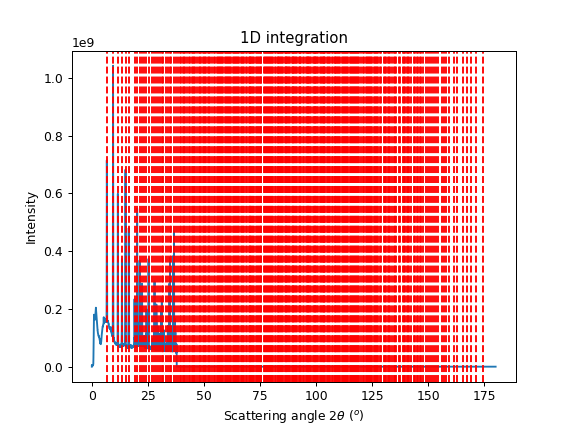

<IPython.core.display.Javascript object>


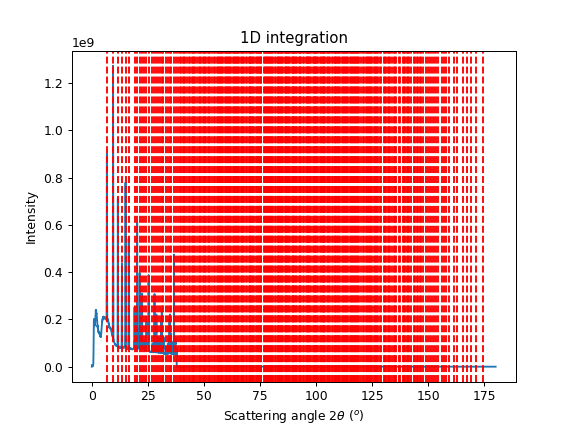

(array([  1.80000021e-03,   5.40000021e-03,   9.00000021e-03, ...,
          1.79991000e+02,   1.79994600e+02,   1.79998200e+02]),
 array([       0.        ,  5495590.02198056,  5507701.4390775 , ...,
               0.        ,        0.        ,        0.        ]))

In [28]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate_mars_tx_tz(json, params, f, plot_calibrant=True, n=50000)
integrate_mars_tx_tz(json, params, f, lst_mask=mask, plot_calibrant=True, n=50000)

In [ ]:
# il faudrait faire une calibration avec l'ensemble des fichiers des scan3 et 4.
# scan3 10 images tx variant et tz=0.
# scan4 10 imagfes tx variant et tz = -1.

# TODO add the second scan for the calibration.
# TODO mask

## Integration <a name="integration"></a>

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


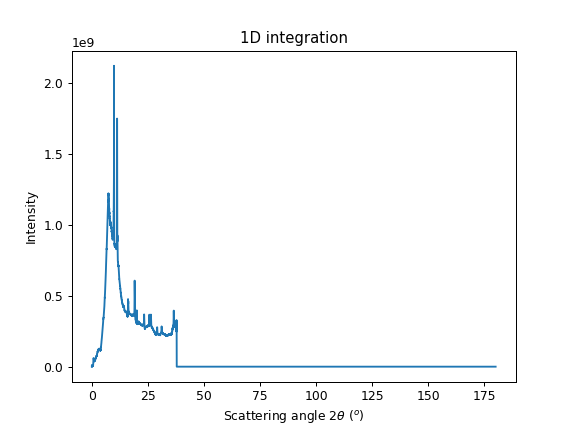

<IPython.core.display.Javascript object>


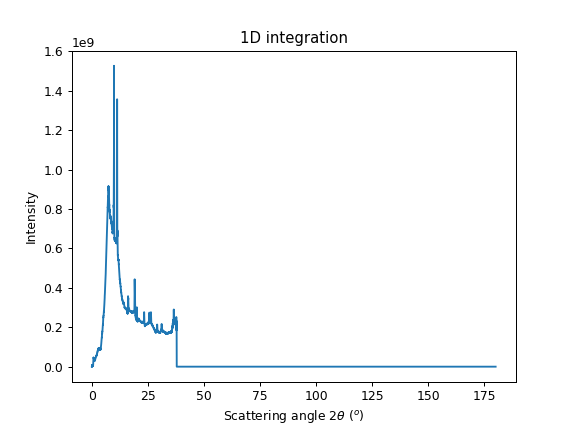

<IPython.core.display.Javascript object>


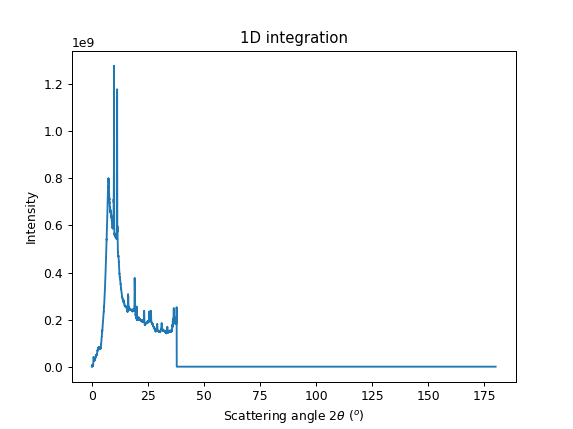

<IPython.core.display.Javascript object>


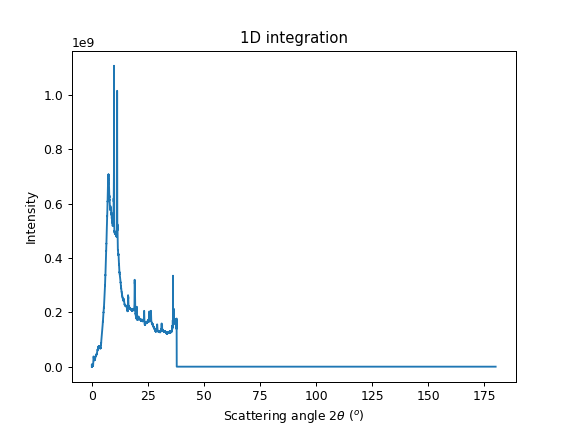

<IPython.core.display.Javascript object>


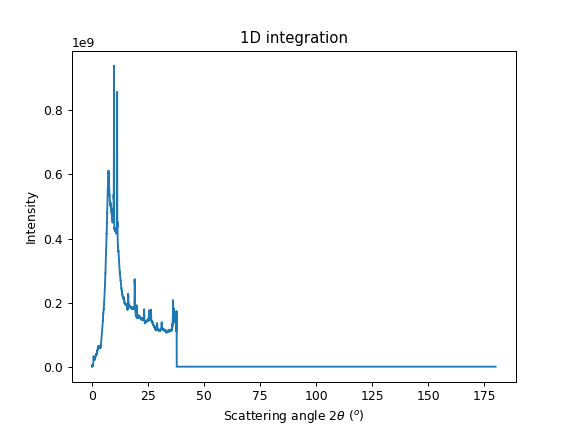

<IPython.core.display.Javascript object>


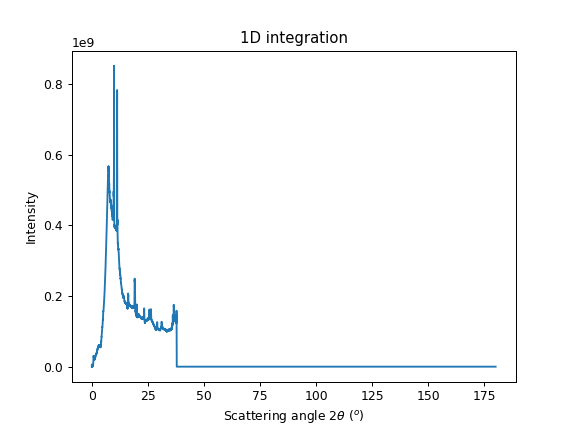

<IPython.core.display.Javascript object>


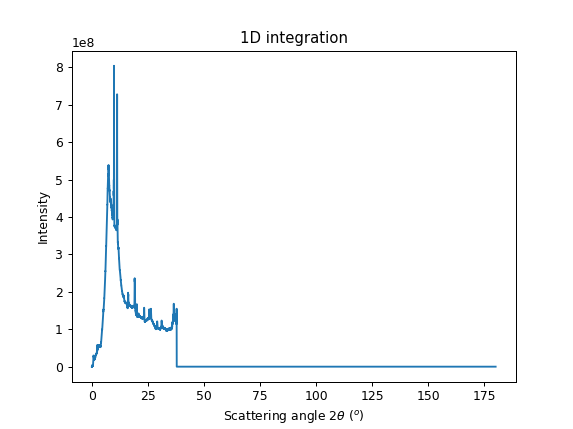

<IPython.core.display.Javascript object>


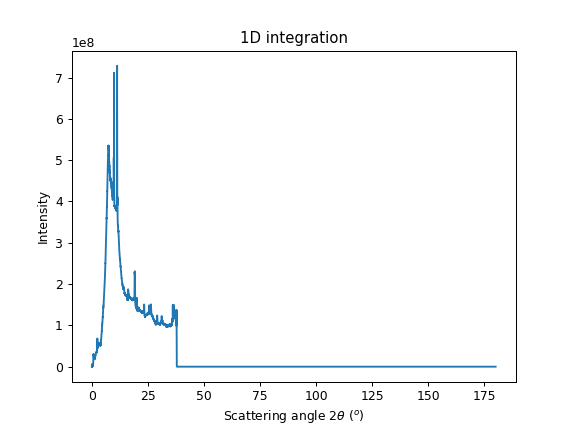

In [29]:
def mkSampleMarsTxTz(filename: str):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("scan_data/actuator_1_1"),  # tx
                               DatasetPathContains("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value"),  # tz
                               None,
                               lambda x: True,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions,
                               6 # max_rings
                              ) 

def mkSampleMarsTxTzP(idx):
    return [mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx))),
            mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx+1)))]


samples = [mkSampleMarsTxTzP(idx) for idx in range(77, 92, 2)]

# add button for each file
for sampless in samples:
    for sample in sampless:
        my_cmd_button("silx view --use-opengl-plot " + sample.filename,
                      'Silx View ' + os.path.basename(sample.filename))
        
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 10000, 0, img)
    return img

for sample in samples:
    integrate_mars_tx_tz(json, sample, f, lst_mask=mask, n=50000, save=True)

In [9]:
def mkSampleMarsTxTz(filename: str):
    return CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd"),
                               filename,
                               DatasetPathWithAttribute("interpretation", b"image"),  # images
                               DatasetPathContains("MARS/D03-1-CX0__EX__SPARE1-MT__#1/raw_value"),  # tx                               
                               DatasetPathContains("scan_data/actuator_1_1"),  # tz
                               None,
                               lambda x: True,
                               Calibrant("LaB6"),
                               Detector("xpad_flat"),
                               Wavelength(4.85945727522e-11),
                               functions,
                               6 # max_rings
                              )

def mkSampleMarsTxTzP(idx):
    return [mkSampleMarsTxTz(os.path.join(ROOT, "scan_{}_01.nxs".format(idx)))]


samples = [mkSampleMarsTxTzP(idx) for idx in chain(range(194, 206), 
                                                   range(211, 237),
                                                   range(238, 255),
                                                   range(399, 520),
                                                   range(522, 524),
                                                   range(528, 529),
                                                   range(530, 582))]
                             
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

for sample in samples:
    #print(sample)
    integrate_mars_tx_tz(json, sample, f, n=50000, save=True, no_plot=True)

area_pixel=2.349807733349531 area_sum=2.3889887146976205, Error= -0.016674122223710175
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.384760217370904, Error= -0.026752411075776677
area_pixel=2.3226244142658294 area_sum=2.38